In [1]:
!git branch
!git checkout TFT
!git branch

* TFT
  main
M	TFT/Business/TFT_CNI_bus.ipynb
M	TFT/Residential/.ipynb_checkpoints/TFT_CNI-checkpoint.ipynb
M	TFT/Residential/.ipynb_checkpoints/TFT_LNI-checkpoint.ipynb
M	TFT/Residential/.ipynb_checkpoints/TFT_LSI-checkpoint.ipynb
M	TFT/Residential/.ipynb_checkpoints/TFT_UNI-checkpoint.ipynb
M	TFT/Residential/.ipynb_checkpoints/TFT_USI-checkpoint.ipynb
M	TFT/Residential/TFT_CNI.ipynb
M	TFT/Residential/TFT_LNI.ipynb
M	TFT/Residential/TFT_LSI.ipynb
M	TFT/Residential/TFT_UNI.ipynb
M	TFT/Residential/TFT_USI.ipynb
Your branch is ahead of 'origin/TFT' by 2 commits.
  (use "git push" to publish your local commits)


Already on 'TFT'


* TFT
  main


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from torch.nn import MSELoss
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Weather Dataset

In [4]:
electricity_consumption = pd.read_csv("../../ProcessedData/Electricity-ResBusClimateLNI.csv")
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Export prices,Export volumes,Export values,Import prices,Import volumes,Import values,Population
0,2010-01-01,67.866667,17.233333,15.766667,5.766667,18.333333,2.533333,2010.0,1.0,246.968,158.147,1072.0,1160.0,10093.0,904.0,1360.0,8827.0,299300.0
1,2010-02-01,71.333333,18.733333,17.800000,4.833333,7.500000,1.766667,2010.0,2.0,240.083,144.080,1072.0,1160.0,10093.0,904.0,1360.0,8827.0,299300.0
2,2010-03-01,46.000000,16.633333,14.366667,5.766667,22.666667,2.166667,2010.0,3.0,274.398,163.344,1072.0,1160.0,10093.0,904.0,1360.0,8827.0,299300.0
3,2010-04-01,41.733333,14.966667,13.966667,5.433333,17.666667,2.166667,2010.0,4.0,254.165,174.786,1112.0,1264.0,11416.0,920.0,1476.0,9740.0,299300.0
4,2010-05-01,149.600000,12.500000,12.500000,4.733333,14.500000,2.000000,2010.0,5.0,270.760,209.621,1112.0,1264.0,11416.0,920.0,1476.0,9740.0,299300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,45.133333,17.966667,15.400000,5.866667,19.000000,2.033333,2024.0,2.0,247.053,148.392,1362.0,1465.0,16196.0,998.0,2381.0,17050.0,358500.0
170,2024-03-01,61.866667,15.600000,13.333333,5.833333,22.333333,2.366667,2024.0,3.0,253.768,169.994,1362.0,1465.0,16196.0,998.0,2381.0,17050.0,358500.0
171,2024-04-01,117.100000,14.533333,13.333333,4.733333,12.000000,2.200000,2024.0,4.0,243.587,184.402,1433.0,1584.0,18433.0,1029.0,2414.0,17823.0,358500.0
172,2024-05-01,78.700000,10.800000,10.733333,4.600000,16.666667,1.900000,2024.0,5.0,262.416,246.995,1433.0,1584.0,18433.0,1029.0,2414.0,17823.0,358500.0


In [5]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

In [6]:
# training and validation split
training_cutoff = pd.Timestamp('2021-01-01')
train, val = ts.split_before(training_cutoff)

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

train_target_og = train['Selected business demand (GWh)']
val_target_og = val['Selected business demand (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov = train_transformed[
    [ 
        'Mean Air Temperature in Celsius', 
        'Mean Vapour Pressure Hpa'
    ]
]

# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)

In [21]:
series_transformed = series_transformed.pd_dataframe()
series_transformed = series_transformed.apply(lambda col: col.fillna(col.mean()))
series_transformed = TimeSeries.from_dataframe(series_transformed)

# Model Training Forecasting

In [22]:
# with past covariates
input_chunk_length = 72
forecast_horizon = 42

my_model_withpast = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=120,
    lstm_layers=2,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=30,
    n_epochs=150,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
    optimizer_kwargs={"lr": 1e-2},  
    log_tensorboard=False,          
    save_checkpoints=True,        
    force_reset=True,  
)
my_model_withpast.fit(train_target, past_covariates = train_past_cov, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

TFTModel(output_chunk_shift=0, hidden_size=120, lstm_layers=2, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=72, output_chunk_length=42, batch_size=30, n_epochs=150, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'future': ['month', 'year']}}, random_state=5, optimizer_kwargs={'lr': 0.01}, log_tensorboard=False, save_checkpoints=True, force_reset=True)

In [23]:
# without past covariates
input_chunk_length = 72
forecast_horizon = 42

my_model_nopast = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=120,
    lstm_layers=2,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=30,
    n_epochs=150,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
    optimizer_kwargs={"lr": 1e-2},  
    log_tensorboard=False,          
    save_checkpoints=True,        
    force_reset=True,  
)

my_model_nopast.fit(train_target, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

TFTModel(output_chunk_shift=0, hidden_size=120, lstm_layers=2, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=72, output_chunk_length=42, batch_size=30, n_epochs=150, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'future': ['month', 'year']}}, random_state=5, optimizer_kwargs={'lr': 0.01}, log_tensorboard=False, save_checkpoints=True, force_reset=True)

In [10]:
from darts.metrics import mape, mae, rmse

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

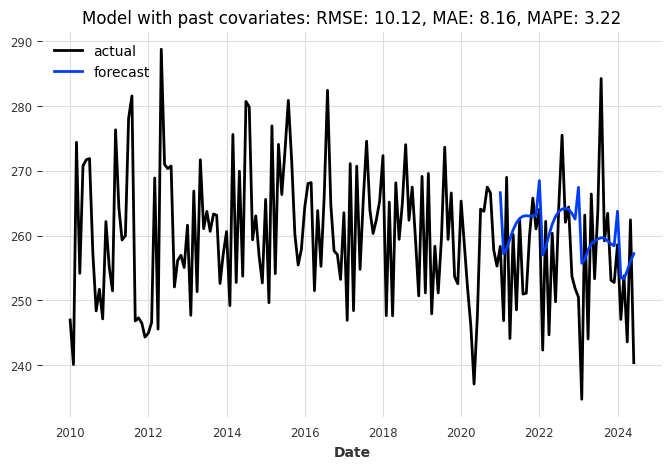

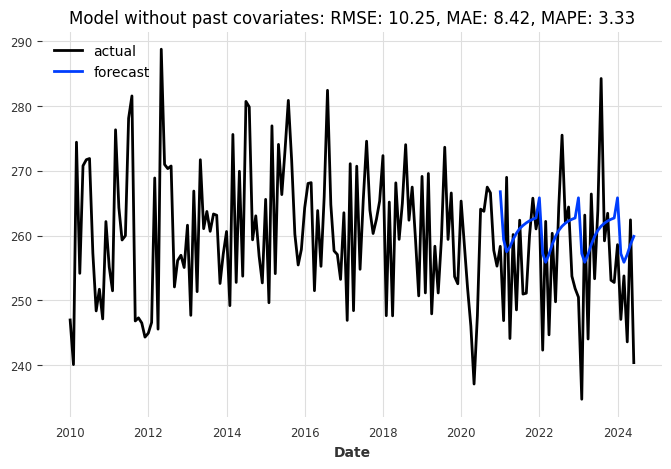

In [24]:
def eval_model(model, num):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    pred_series_reversed = transformer_target.inverse_transform(pred_series)
    ts['Selected business demand (GWh)'].plot(label="actual")
    pred_series_reversed['Selected business demand (GWh)'].plot(label="forecast")
    if num == 1:
        plt.title("Model with past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series
    else:
        plt.title("Model without past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series

pred_series_transformed = eval_model(my_model_withpast, 1)
pred_series_transformed_no_past_cov = eval_model(my_model_nopast, 0)

# Backtesting

In [28]:
model_TFT_backtest = TFTModel(
    input_chunk_length=66,
    output_chunk_length=3,
    hidden_size=100,
    lstm_layers=2,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=30,
    n_epochs=100,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
    optimizer_kwargs={"lr": 1e-2},  
    log_tensorboard=False,          
    save_checkpoints=True,        
    force_reset=True,  
)


Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

MAPE: 6.15%, RMSE: 28.70


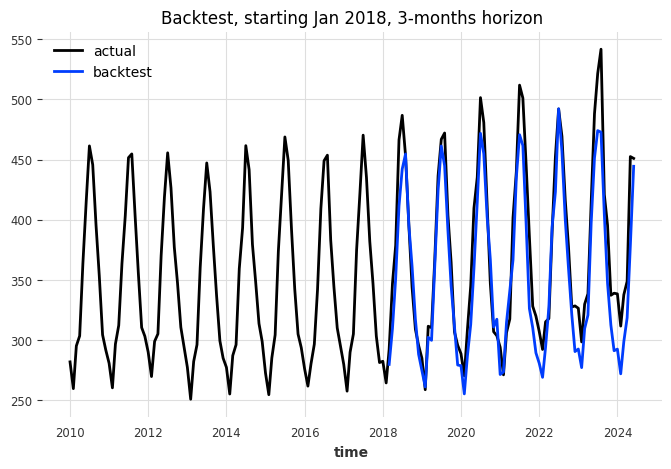

In [29]:
# with past covariates
backtest_series = model_TFT_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],               
    past_covariates=series_transformed[['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']],   
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

MAPE: 6.03%, RMSE: 28.72


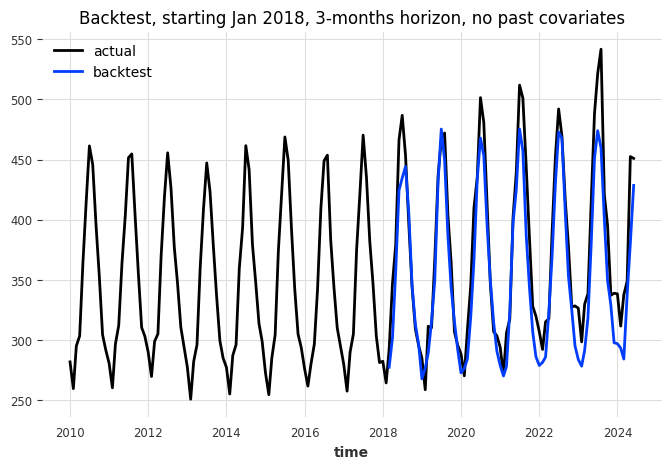

In [30]:
# without past covariates
backtest_series = model_TFT_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon, no past covariates")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)